In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os
import networkx as nx
import re
import scipy.stats

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from parliament.utils import merge_utterance_paragraphs

In [4]:
# function definitions for correlations

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id, method='pearson'):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr(method=method)
    #values = corr.values
    #cols = corr.columns
    
    if method is 'pearson':
        # calculate p-values for pearson correlation coefficient
        pvalues = calculate_pvalues(df)
    else:
        pvalues = None

    return corr, pvalues
    # end def correlate_topics

# to get p_values:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = scipy.stats.pearsonr(df[r], df[c])[1]
    return pvalues

def filter_occurrence(run_id, dts, filter_occurrence_no, party_name=None, period_list=None):
    stat = RunStats.objects.get(run_id=run_id)
    regular_expression = stat.psearch.text
    SEARCH = re.compile(regular_expression, re.IGNORECASE)

    print("filtering for speeches with {} or more occurrences of\n{}".format(filter_occurrence_no,
                                                                             regular_expression))
    pre_dts_len = len(dts)

    uts = pm.Utterance.objects.filter(search_matches=stat.psearch).order_by('id')
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    if period_list:
         uts = uts.filter(document__parlperiod__n__in=period_list)
    
    texts, docsizes, ids = merge_utterance_paragraphs(uts)

    selected_ut_ids = []
    for i, text in enumerate(texts):
        if len(SEARCH.findall(text)) >= filter_occurrence_no:
            selected_ut_ids.append(ids[i])

    dts = dts.filter(ut__id__in=selected_ut_ids)
    print("ids: filtered {} from {}, ratio: {}".format(len(selected_ut_ids), len(ids), len(selected_ut_ids)/len(ids)))
    print("dts: filtered {} from {}, ratio: {}".format(len(dts), pre_dts_len, len(dts)/pre_dts_len))
    
    return dts

# function for calculating topic correlation
# with slicing by party and/or parliamentary periods

def corr_topics(run_id, party_name=None, period_list=None, filter_occurrence_no=0, method='pearson'):
    print("Calculating topic correlation for party {} and periods {} in run {}".format(party_name, period_list, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period_list:
            dts = dts.filter(ut__document__parlperiod__n__in=period_list)
        if filter_occurrence_no:
            dts = filter_occurrence(run_id, dts, filter_occurrence_no,
                                    party_name=party_name, period_list=period_list)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    #corr, pvalues = correlate_topics(df, doc_id, method=method)
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return df

In [191]:
def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    ids = {}
    scores = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        ids[i] = topic.id
        #top_words[i] = ", ".join(topic.top_words)
        scores[i] = topic.score
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, ids, name="id")
    nx.set_node_attributes(G, scores, name="totalscores")

    nx.set_node_attributes(G, top_words, name="topwords")
    
    weights = {}
    for i in range(len(topic_ids)):
        for j in range(len(topic_ids)):
            weights[(i, j)] = float(corr.values[i][j])
    
    nx.set_edge_attributes(G, weights, "weight")

    return G
    
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()

def get_off_diagonal_elements(array):
    vals = array.astype(np.float)
    np.fill_diagonal(vals, np.nan)
    return vals[~np.isnan(vals)].flatten()

def corr_hist(corr, threshold_pct, bins=50, log=False, off_diagonal=True):
    if off_diagonal:
        vals = get_off_diagonal_elements(corr.values)
    else:
        vals = corr.values.flatten()
        
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=bins, log=log)
    return threshold

In [6]:
df = corr_topics(2350)

Calculating topic correlation for party None and periods None in run 2350
filtered docs * K: 320845
df shape: (320845, 3)


In [13]:
df

,score,topic_id,ut_id
0,0.010000,184079,2819178
1,0.010000,184079,2828214
2,0.010000,184079,2815807
3,0.010000,184079,2817081
4,0.010000,184079,2826544
5,0.010000,184079,2813718
6,0.010000,184079,2819013
7,0.010000,184079,2832170
8,0.010000,184079,2826714
9,0.010000,184079,2813108


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


topic_id
184079    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184080    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184081    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184082    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184083    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184084    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184085    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184086    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184087    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184088    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184089    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184090    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184091    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184092    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184093    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184094    [[Axes(0.125,0.125;0.336957x0.755), Axes(0.563...
184095    [[Axes(0.125,0.125;0.

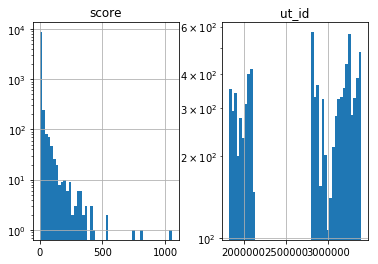

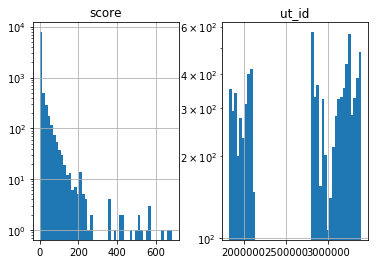

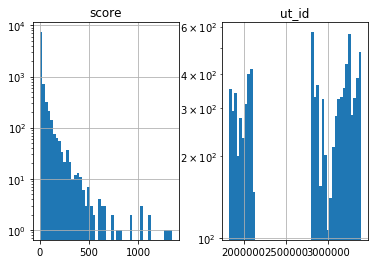

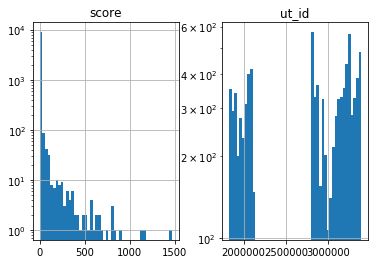

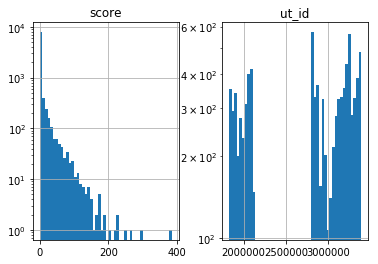

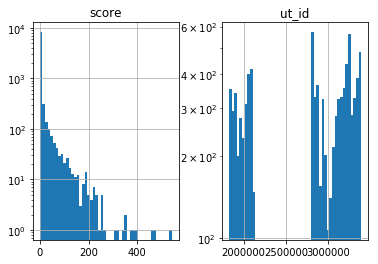

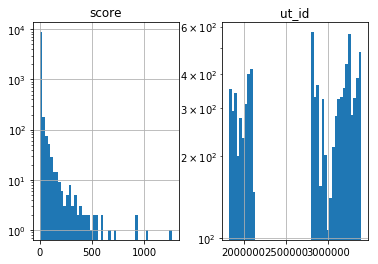

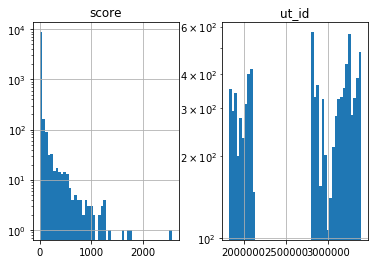

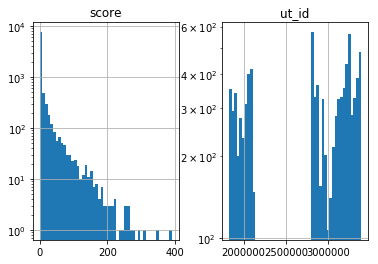

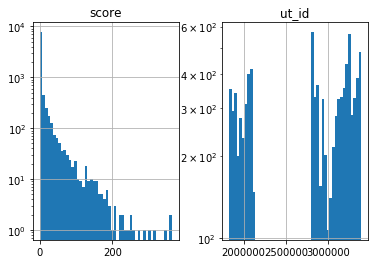

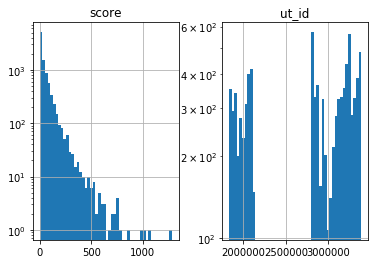

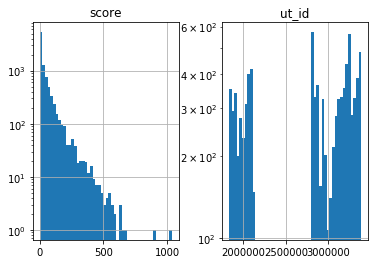

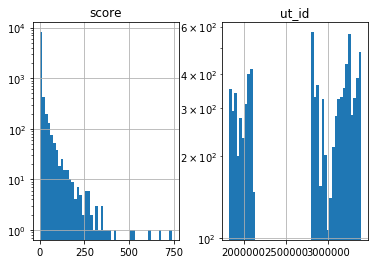

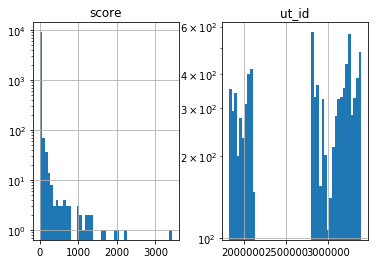

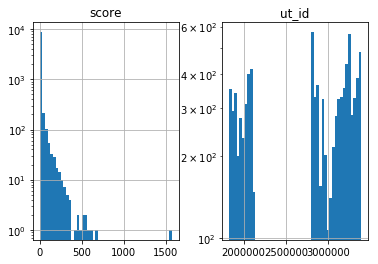

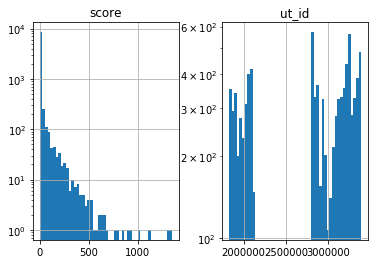

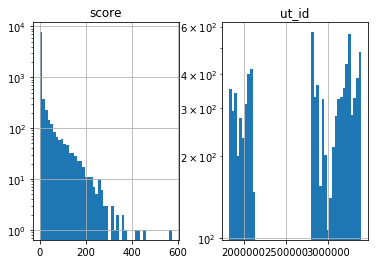

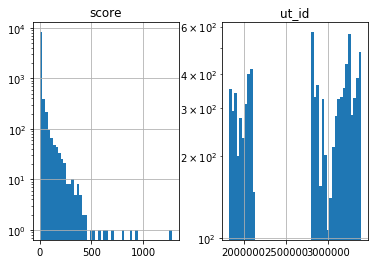

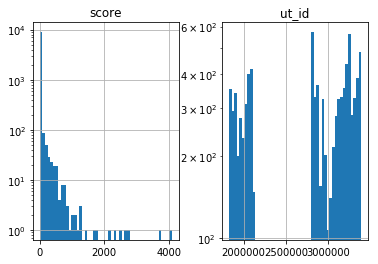

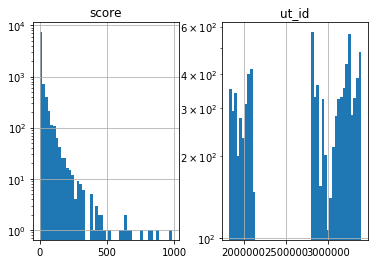

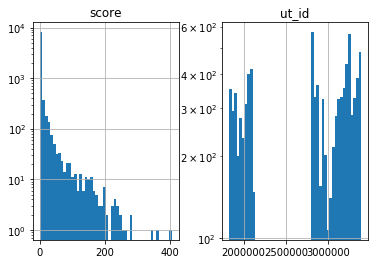

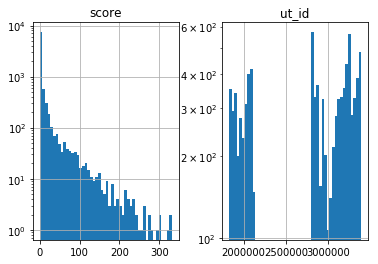

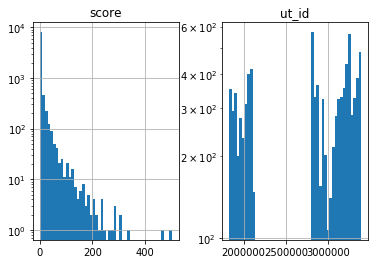

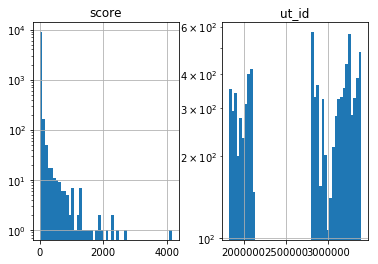

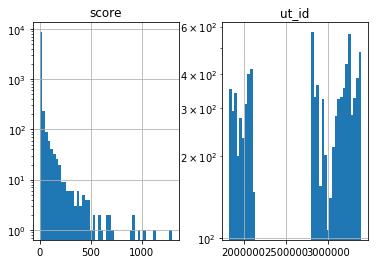

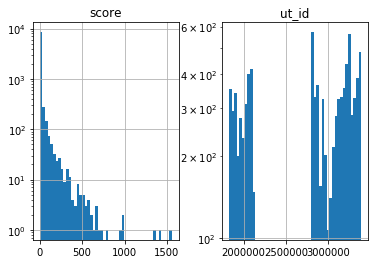

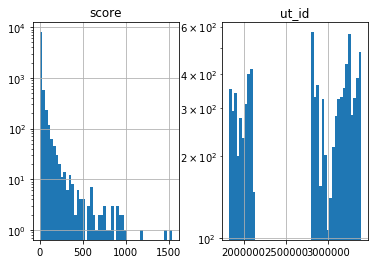

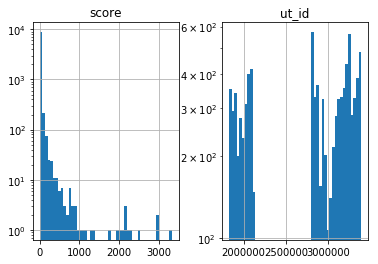

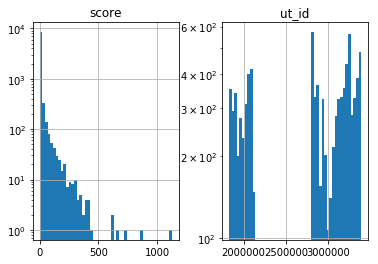

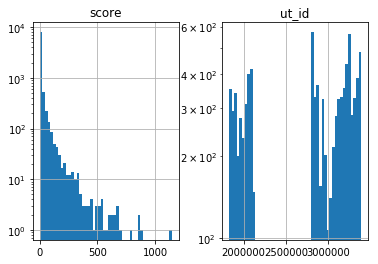

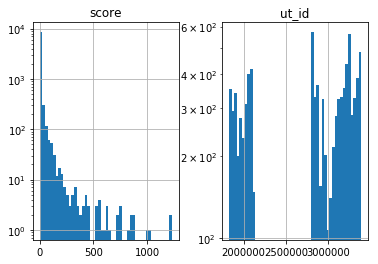

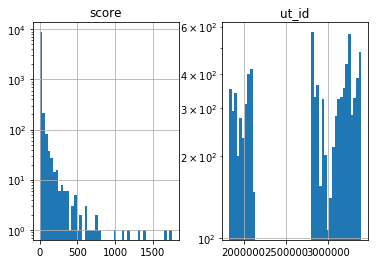

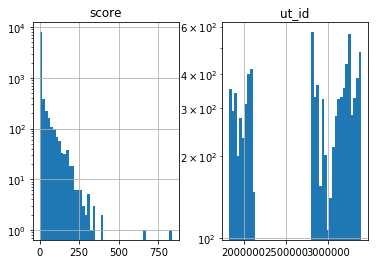

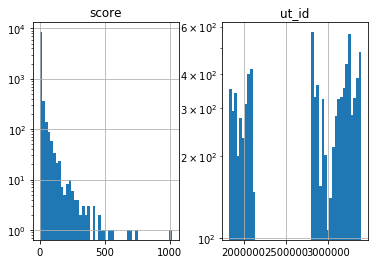

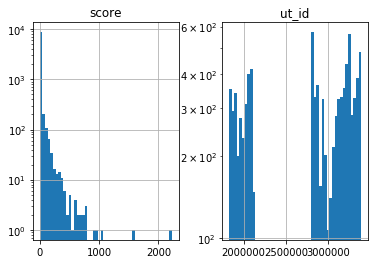

In [12]:
# histograms of topic scores by topic
df.groupby('topic_id').hist(bins=50, log=True)

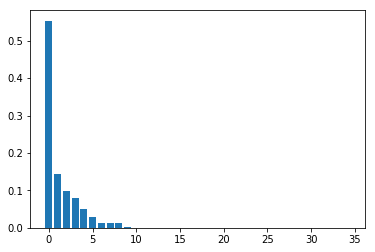

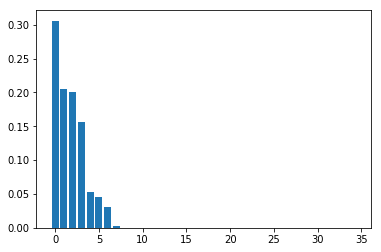

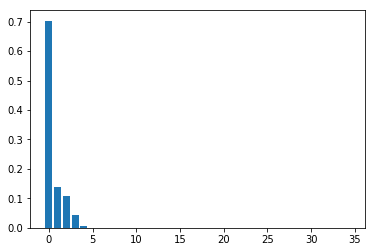

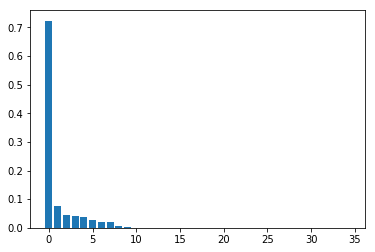

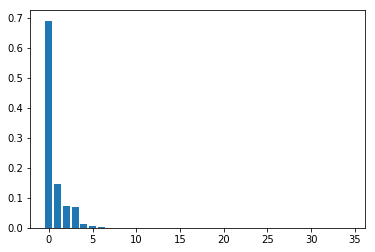

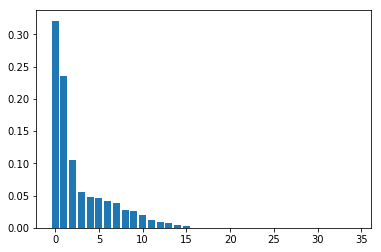

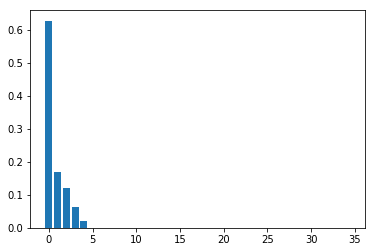

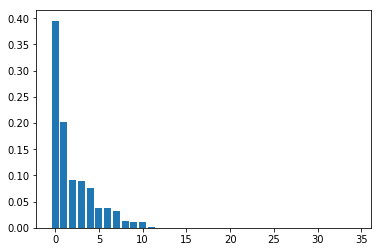

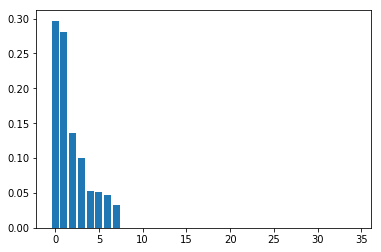

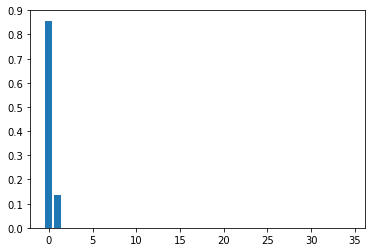

In [35]:
# topic distribution in single documents

ut_ids = df.ut_id.unique()[0:10]

for ut_id in ut_ids:
    fig = plt.figure()
    selection = df[df['ut_id'] == ut_id]
    shares = selection.sort_values('score', ascending=False)['score'].values / selection['score'].sum()
    plt.bar(range(0, len(shares)), shares)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7572913e80>]],
      dtype=object)

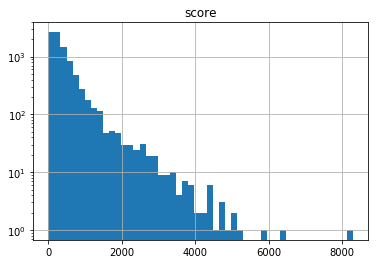

In [39]:
# histogram of score sums in documents
df[['ut_id','score']].groupby('ut_id').sum().hist(bins=50, log=True)

In [198]:
score_sums = df[['ut_id','score']].groupby('ut_id').sum()
joined_df = df.join(score_sums, on='ut_id', rsuffix='_sum')

# use threshold of 10 or 5 % of total scores to define event
joined_df['event'] = (joined_df['score'] > 0.1* joined_df['score_sum'])

topics_times_docs = df.ut_id.unique().size * df.topic_id.unique().size
print("events: {} of {} ({})".format(joined_df['event'].sum(), topics_times_docs, joined_df['event'].sum()/topics_times_docs))
print("on average {} topics per document".format(joined_df['event'].sum() / df.ut_id.unique().size))

events: 28790 of 320845 (0.0897318019604482)
on average 3.1406130686156866 topics per document


In [199]:
joined_df['neg_event'] = ~joined_df['event']
joined_df.neg_event = joined_df.neg_event.astype(int)

doc_topic_neg_df = joined_df.pivot(
            index='ut_id',
            columns='topic_id',
            values='neg_event'
            )

joined_df.event = joined_df.event.astype(int)

doc_topic_df = joined_df.pivot(
            index='ut_id',
            columns='topic_id',
            values='event'
            )

doc_topic_df.corr(method='pearson')

topic_id,184079,184080,184081,184082,184083,184084,184085,184086,184087,184088,...,184104,184105,184106,184107,184108,184109,184110,184111,184112,184113
topic_id,,,,,,,,,,,,,,,,,,,,,
184079,1.000000,-0.050657,-0.038981,-0.032781,0.009114,-0.018903,-0.051414,-0.039189,-0.054268,0.048873,...,-0.028297,-0.023742,-0.042544,-0.038786,-0.005915,-0.034545,-0.007447,-0.055182,-0.033311,-0.018780
184080,-0.050657,1.000000,-0.084411,-0.039166,0.016152,-0.012043,-0.075397,-0.056805,0.040477,-0.059967,...,-0.033811,-0.001230,-0.069758,-0.050129,-0.084296,-0.043811,-0.044935,0.170186,-0.043633,-0.098558
184081,-0.038981,-0.084411,1.000000,0.043139,-0.072326,0.010112,0.039844,0.022909,-0.032168,-0.052735,...,-0.008192,-0.065273,-0.015734,-0.002722,-0.003853,0.164183,0.013354,-0.102595,0.009107,0.039395
184082,-0.032781,-0.039166,0.043139,1.000000,-0.031584,-0.033412,-0.029635,0.007068,-0.024979,-0.034979,...,-0.025584,-0.019393,-0.002578,0.005162,-0.035333,-0.007845,-0.011049,-0.046277,0.003773,0.040933
184083,0.009114,0.016152,-0.072326,-0.031584,1.000000,0.001293,-0.062534,-0.062692,0.009760,0.077318,...,-0.036522,-0.034565,-0.055851,-0.065254,0.014729,-0.039703,-0.027110,0.109385,0.005952,-0.078665
184084,-0.018903,-0.012043,0.010112,-0.033412,0.001293,1.000000,-0.041356,-0.060674,0.028619,-0.038600,...,-0.013409,-0.033893,0.034606,-0.002074,-0.040218,-0.035357,-0.037607,-0.060002,-0.004994,-0.067931
184085,-0.051414,-0.075397,0.039844,-0.029635,-0.062534,-0.041356,1.000000,0.018326,-0.069051,-0.042574,...,-0.048377,-0.029918,0.007822,0.085024,-0.021648,0.008478,0.006305,-0.094502,0.010979,0.179328
184086,-0.039189,-0.056805,0.022909,0.007068,-0.062692,-0.060674,0.018326,1.000000,-0.057247,-0.063970,...,-0.056771,0.070426,-0.040022,0.020176,-0.074489,-0.017402,0.029196,-0.079488,-0.028441,0.094067
184087,-0.054268,0.040477,-0.032168,-0.024979,0.009760,0.028619,-0.069051,-0.057247,1.000000,-0.050905,...,0.029905,-0.011607,0.011451,-0.052762,-0.073577,-0.035561,-0.038163,-0.010288,-0.019708,-0.091570


In [200]:
joined_df

,score,topic_id,ut_id,score_sum,event,neg_event
0,0.010000,184079,2819178,369.35,0,1
1,0.010000,184079,2828214,520.35,0,1
2,0.010000,184079,2815807,147.35,0,1
3,0.010000,184079,2817081,703.35,0,1
4,0.010000,184079,2826544,671.35,0,1
5,0.010000,184079,2813718,647.35,0,1
6,0.010000,184079,2819013,895.35,0,1
7,0.010000,184079,2832170,554.35,0,1
8,0.010000,184079,2826714,216.35,0,1
9,0.010000,184079,2813108,54.35,0,1


threshold: 0.017453910766881204


0.017453910766881204

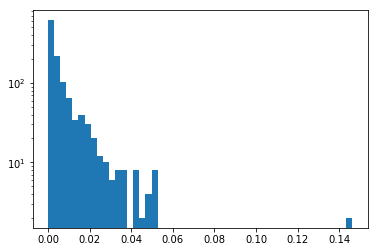

In [201]:
dot_product = doc_topic_df.transpose().dot(doc_topic_df)
norm_dot_product = dot_product / df.ut_id.unique().size

corr_hist(norm_dot_product, 90, log=True, off_diagonal=True)

threshold: 8318.0


8318.0

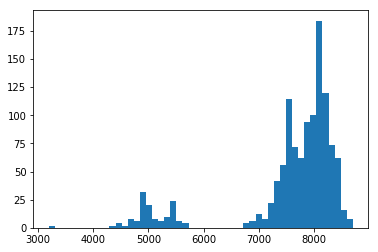

In [202]:
neg_dot_product = doc_topic_neg_df.transpose().dot(doc_topic_neg_df)
non_negative_uts = df.ut_id.unique().size - neg_dot_product
corr_hist(neg_dot_product, 90)

In [ ]:
# co-occurrance in the left peak is with the two topics 'stop words' and 'procedural' (ids: 184089 and 184090)

In [209]:
Topic.objects.get(id= 184090).title

'procedural'

threshold: 0.07127833605982706


0.07127833605982706

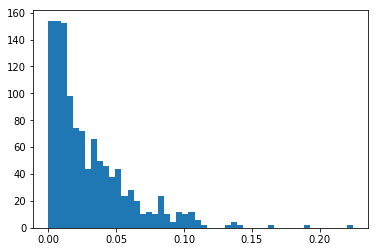

In [203]:
event_sync = dot_product / non_negative_uts
corr_hist(event_sync, 90, off_diagonal=True)

threshold: 0.06952154374834787


0.06952154374834787

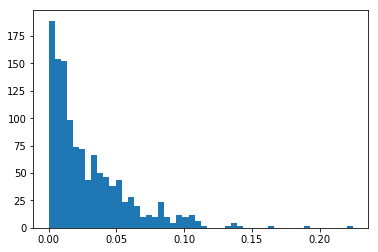

In [204]:
event_sync = dot_product / non_negative_uts
corr_hist(event_sync, 90, off_diagonal=False, old=True)

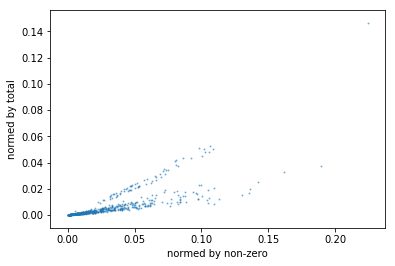

In [205]:
plt.scatter(get_off_diagonal_elements(event_sync.values), get_off_diagonal_elements(norm_dot_product.values), alpha=0.25, s=1)
plt.xlabel('normed by non-zero')
plt.ylabel('normed by total')

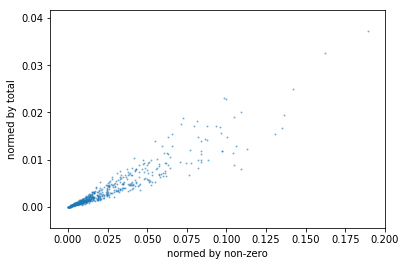

In [221]:
# split is due to the topics 'stop words' and 'procedural'
# without them:

x = event_sync.drop([184089, 184090]).drop([184089, 184090],axis=1)
x = get_off_diagonal_elements(x.values)

y = norm_dot_product.drop([184089, 184090]).drop([184089, 184090], axis=1)
y = get_off_diagonal_elements(y.values)

plt.scatter(x, y, alpha=0.25, s=1)
plt.xlabel('normed by non-zero')
plt.ylabel('normed by total')

In [ ]:
# compile this to a function

def event_synchronization(df, norm='total'):
    score_sums = df[['ut_id','score']].groupby('ut_id').sum()
    joined_df = df.join(score_sums, on='ut_id', rsuffix='_sum')

    # use threshold of 10 or 5 % of total scores to define event
    joined_df['event'] = (joined_df['score'] > 0.1* joined_df['score_sum'])

    topics_times_docs = df.ut_id.unique().size * df.topic_id.unique().size
    print("events: {} of {} ({})".format(joined_df['event'].sum(), topics_times_docs, joined_df['event'].sum()/topics_times_docs))
    print("on average {} topics per document".format(joined_df['event'].sum() / df.ut_id.unique().size))
    
    if norm is 'nonzero':
        joined_df['neg_event'] = ~joined_df['event']
        joined_df.neg_event = joined_df.neg_event.astype(int)

        doc_topic_neg_df = joined_df.pivot(
                    index='ut_id',
                    columns='topic_id',
                    values='neg_event'
                    )

    joined_df.event = joined_df.event.astype(int)

    doc_topic_df = joined_df.pivot(
                index='ut_id',
                columns='topic_id',
                values='event'
                )
    
    dot_product = doc_topic_df.transpose().dot(doc_topic_df)
    
    if norm is 'total':
        event_sync = dot_product / df.ut_id.unique().size
    
    elif norm is 'nonzero':
        neg_dot_product = doc_topic_neg_df.transpose().dot(doc_topic_neg_df)
        non_negative_uts = df.ut_id.unique().size - neg_dot_product

        event_sync = dot_product / non_negative_uts
    else:
        print("norm keyword not known")
        return 0
    
    return event_sync
